# DFT and/vs LSTM for time series prediction

## DFT

### Theory recap

Note: 
- We'll only deal with Real valued signals
- We'll use torch as we'll deal with LSTMs later, but the commands for numpy and scipy are almost identical.
- We'll set the sample rate `fs=1`

First let's review some things that we need to know about the Discrete Fourier Transform (DFT)

**1) FFT stands for Fast Fourier Transform and is the `O(nlog(n))` algorithm typically used to compute the DFT.**

Hence torch.fftm numpy.fft, scipy.fft.

**2) The DFT is a linear operation that maps a signal of N samples onto N complex values which represent the amplitudes and phases of the harmonics/components that make up the signal.**

The frequencies of these components are determined by `N` and the sample rate `fs`: `f[k]=k*fs/N`, or simply `f[k]=k/N` in our case.

**3) While there are N components in the DFT, these only correspond to about `N/2` different and unique fundamental frequencies.**

That is becasue the DFT maps the signal onto a given positive frequency and its negative separately. The two are functionally equivalent and when dealing with real valued signals the two corresponding amplitueds are added together and we just work with the positive frequency.

Specifically we have,

if N is even:
- `N/2`  positive frequency components, including the DC component (the constant value/offset of the signal). 
- `1` value for the Nyquist component `fs/2` (the highest possible frequency) 
- So `N/2+1` in total.

The frequencies will be `f = [0, 1/N, 2/N, ..., 1/2]`

The periods will be     `T = [0, N, N/2, ..., 2]`

if N is odd:
- `(N+1)/2`  positive frequency components including the DC component.
-  Note that we don't reach the Nyquist component in this case, the highest frequency component in the DFT will be slightly below it.

The frequencies will be `f = [0, 1/N, 2/N, ..., 1/2 - 1/2N]`

The periods will be     `T = [0, N, N/2, ..., 2N/(N-1)]`


Let's explore the above in torch and see if we get what we expect.

In [12]:
import torch
# Even N
print("EVEN")
N = 16
expected_components = N/2 + 1
y = torch.arange(N)
dft = torch.fft.rfft(y)
assert int(expected_components) == len(dft)
print(len(dft), expected_components, dft.dtype)

f = torch.fft.rfftfreq(N)
T = 1/torch.fft.rfftfreq(N)
T[0]=0
print(f)
print(T)

# Odd N
print("ODD")
N=15
expected_components = (N+1)/2
y = torch.arange(N)
dft = torch.fft.rfft(y)
assert int(expected_components) == len(dft)
print(len(dft), expected_components, dft.dtype)

f = torch.fft.rfftfreq(N)
T = 1/torch.fft.rfftfreq(N)
T[0]=0
print(f)
print(T)


EVEN
9 9.0 torch.complex64
tensor([0.0000, 0.0625, 0.1250, 0.1875, 0.2500, 0.3125, 0.3750, 0.4375, 0.5000])
tensor([ 0.0000, 16.0000,  8.0000,  5.3333,  4.0000,  3.2000,  2.6667,  2.2857,
         2.0000])
ODD
8 8.0 torch.complex64
tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667])
tensor([ 0.0000, 15.0000,  7.5000,  5.0000,  3.7500,  3.0000,  2.5000,  2.1429])


To get the corresponding aplitudes we do:

In [13]:
amplitudes = torch.abs(dft) / N # Scale by N to retieve the actual valued of the amplitudes of the harmonics
phases = torch.angle(dft)
print(len(amplitudes), amplitudes)
print(len(phases), phases)

8 tensor([7.0000, 2.4049, 1.2293, 0.8507, 0.6728, 0.5774, 0.5257, 0.5028])
8 tensor([0.0000, 1.7802, 1.9897, 2.1991, 2.4086, 2.6180, 2.8274, 3.0369])


### Exploration: DFT in pratice

Let's familiarize whith how the DFT works in practice.

While obtaining values for the amplitudes, pahses, frequencies etc...is intersting it doe snto help much in understadning.
What is more helpful is to understand the opposite direction of how the frequencies come together to build the signal and predict the signal beyond the sampling window.

So we will do `signal -> dft -> mess with the dft -> see how well the signal is reconstructed inside and outside the sampling window. `

Let's define some helper functions.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import wandb
from pathlib import Path

np.random.seed(0)  # Seed for reproducibility

def generate_signal(num_samples=118, noise=False, num_components=(3, 7), periods_range=(2, 100)):
    """
    :param num_samples: Total number of samples in the signal
    :return: 
    """        
    if type(num_components) == int:
        num_components = (num_components, num_components+1)
    else:
        assert num_components[0] < num_components[1]
    if type(periods_range) == int:
        periods_range = (periods_range, periods_range+1)
    else:
        assert periods_range[0] <= periods_range[1]

    num_components = np.random.randint(*num_components)  # Randomly choose how many periods to combine
    
    periods = np.random.randint(*periods_range, num_components)  # Period lengths in samples
    phases = np.random.rand(num_components) * 2 * np.pi
    amplitudes = np.random.rand(num_components)
    amplitudes /= np.sum(amplitudes)

    # Sample indices
    samples = np.arange(num_samples)

    # Generate a random continuous periodic signal
    signal = sum(amplitude * np.sin(2 * np.pi * (1 / period) * samples + phase) for amplitude, period, phase in zip(amplitudes, periods, phases))
    signal = signal / np.max(np.abs(signal))  # Normalize signal

    # Add random noise to the signal
    if noise:
        noise = np.random.normal(0, 0.1, signal.shape)
        signal += noise
        signal = signal / np.max(np.abs(signal))  # Normalize signal again

    return torch.from_numpy(samples).to(torch.float), torch.from_numpy(signal).to(torch.float)



def get_fft_harmonics(orignal_signal, analysis_samples, hamming_smoothing=False):
    if hamming_smoothing:
        signal_window = orignal_signal[:analysis_samples]
        window = torch.hamming_window(analysis_samples, periodic=False)
        signal_window = signal_window * window
        fft_result = torch.fft.rfft(signal_window)
    else:
        fft_result = torch.fft.rfft(orignal_signal[:analysis_samples])
    amplitudes = torch.abs(fft_result) / analysis_samples
    phases = torch.angle(fft_result)
    
    # Double the amplitudes for non-DC components
    # Note: The last component should not be doubled if N is even and represents the Nyquist frequency
    if analysis_samples % 2 == 0:
        # If the original signal length is even, don't double the last component (Nyquist frequency)
        amplitudes[1: -1] *= 2
    else:
        # If the original signal length is odd, all components except the DC can be doubled
        amplitudes[1:] *= 2
    return amplitudes, phases

def get_signal_from_harmonics(amplitudes, phases, num_samples):
    analysis_samples = len(amplitudes) * 2 - 2  # Adjust for rfft output length
    reconstructed_signal = torch.zeros(num_samples, dtype=torch.complex64)
    for index, (amplitude, phase) in enumerate(zip(amplitudes, phases)):
        reconstructed_signal += amplitude * torch.exp(1j * (2 * torch.pi * index * torch.arange(num_samples) / analysis_samples + phase))

    # Return the real part of the reconstructed signal
    return reconstructed_signal.real


def reconstruct_signal_fft(orignal_signal, analysis_samples, hamming_smoothing=False):
    # Perform FFT on the entire signal
    amplitudes, phases = get_fft_harmonics(orignal_signal, analysis_samples, hamming_smoothing)

    # Return the real part of the reconstructed signal
    return get_signal_from_harmonics(amplitudes, phases, len(orignal_signal))


We can use `generate_signal` to produce a random signal. We can get a non radom output for just one compoentn with a specified periodicity.

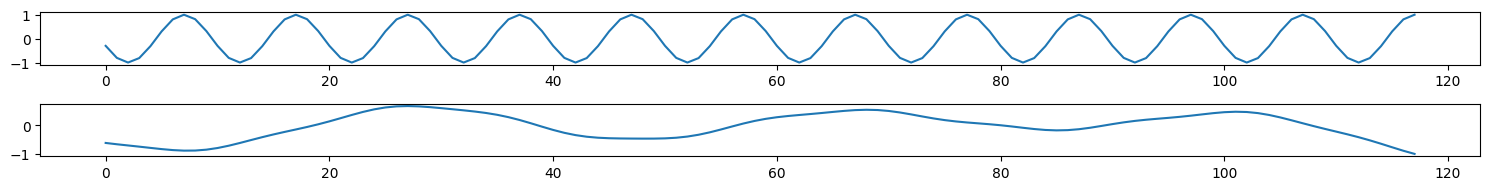

In [15]:
plt.figure(figsize=(15, 2))

plt.subplot(2, 1, 1)
# signal with 1 component with a period of 10 samples
x,y  = generate_signal(num_components=1, periods_range=10)
plt.plot(x,y)
plt.subplot(2, 1, 2)
# signal with a random amount of components and periods
x,y  = generate_signal()
plt.plot(x,y)

plt.tight_layout()
plt.show()



Let's now define a function that takes care of plotting the original signal, the reconstructed signal and the amplitudes and phases of the harmonics.

In [16]:

def plot_signal_and_fft(signal: torch.Tensor, train_test_split_idx: int, hamming_smoothing: bool = False):
    assert (W := signal.shape[0]) >= train_test_split_idx
    t_full = torch.arange(W)


    amplitudes, phases = get_fft_harmonics(signal, train_test_split_idx, hamming_smoothing)
    frequency_bins = np.arange(len(amplitudes), dtype=np.float16)

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.plot(t_full, signal, label="original")
    plt.plot(t_full, get_signal_from_harmonics(amplitudes, phases, W), '-x', label="fft reconstruction")
    plt.axvspan(0, train_test_split_idx-1, color='grey', alpha=0.3)
    plt.xlabel('t [samples]')
    plt.legend(loc='best')
    plt.title('Signal')
    
    fft_frequencies = frequency_bins/train_test_split_idx
    plt.subplot(1, 3, 2)
    plt.xscale('log')
    plt.plot(fft_frequencies, amplitudes)
    plt.xlabel('Frequency [1/samples]')
    plt.title('Amplitudes')

    fft_periods = frequency_bins.copy()
    fft_periods[1:]=train_test_split_idx/fft_periods[1:]
    plt.subplot(1, 3, 3)
    plt.plot(frequency_bins, amplitudes)
    top_5_indices = np.argsort(amplitudes)[-4:]
    top_5_indices[0]=1
    plt.xscale('log')
    plt.xticks(frequency_bins[top_5_indices],fft_periods[top_5_indices], rotation=70)
    plt.xlabel('T [samples]')
    plt.title('Amplitudes')


    plt.tight_layout()
    plt.show()



Now let's start applying the DFT to 1 component and see how we do.
Let's generate 200 samples and do the DFT on the first 100.

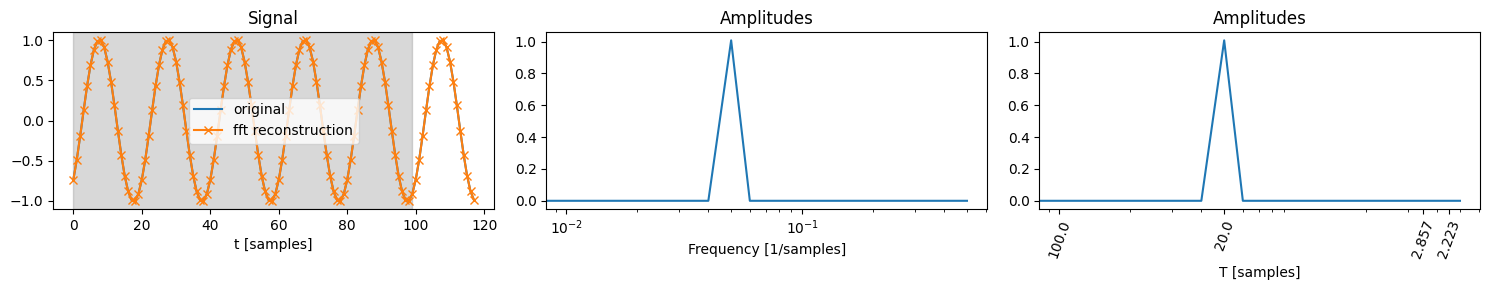

In [17]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 100)

Perfection! The DFT correctyl detects that we have 1 harmonic with a period of 20 samples, and our reconstruction then of course is also spot on outside of th fist 100 samples we did the DFT on.

We tried on 100 samples, then 110 samples must be even better! Let's try.

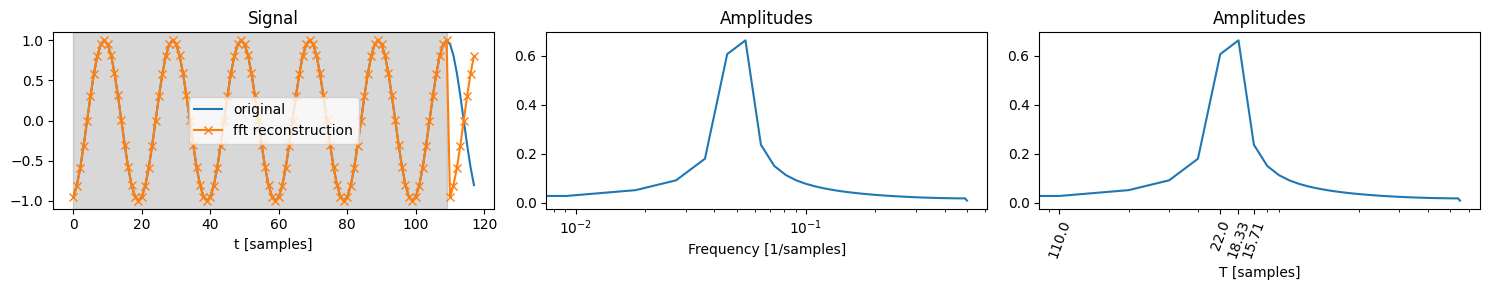

In [18]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 110)

Ouch that is not what one could have hoped for. Why?

**Becasue the DFT "assumes" that all components have a periodicity that completes an integer number of cycles within the sampling window.**

But a sinusoid with a period of 20 does not complete an integre number of cycles in 120 samples. Teh consequence is that the power of the signal get's spread out a bit over more frequencies (amplitude peak is not perfectly narrow on 20). This is known as spectral lekage.

Moreover our "prediction" of the signal outside the sampling window becomes terrible, as the reconstructed signal is just a copy of  the signal inside the sampling window. This is exactly what the DFT assumes: that the sample window we provide it is exactly the period of the signal (up to an integer factor)!

One way to reduce spectral leakage is having smoothing of the signal at the edges of the sampling window towards 0. 

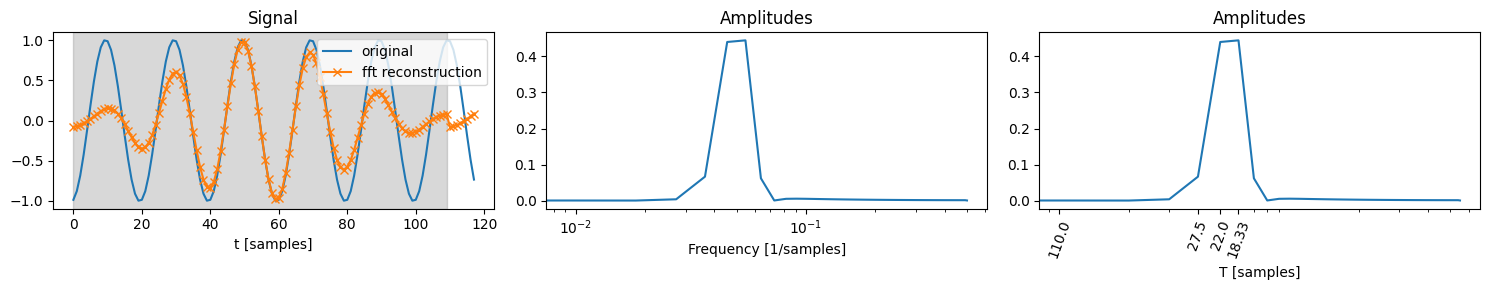

In [19]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 110, hamming_smoothing=True)

This localizes the amplitude peak a bit more, but it certianly doesn't help with the predicitve qualities of out reconstruction

Before we move on let's just look at the DFT of a more complex signal.

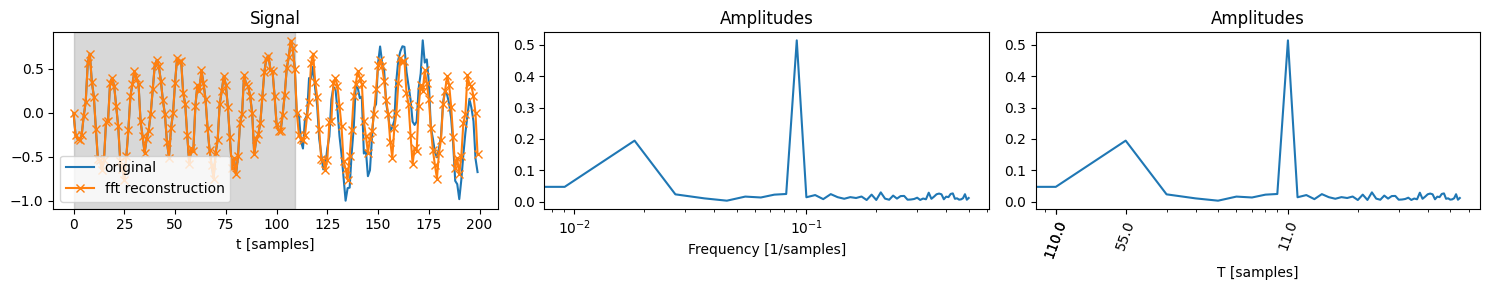

In [20]:
_, y = generate_signal(200, noise=True)
plot_signal_and_fft(y, 110)

###  With Real data

768


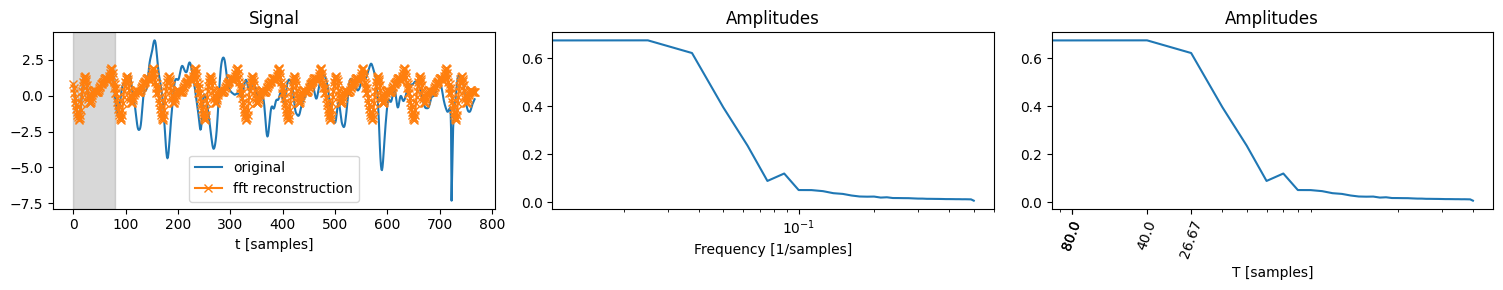

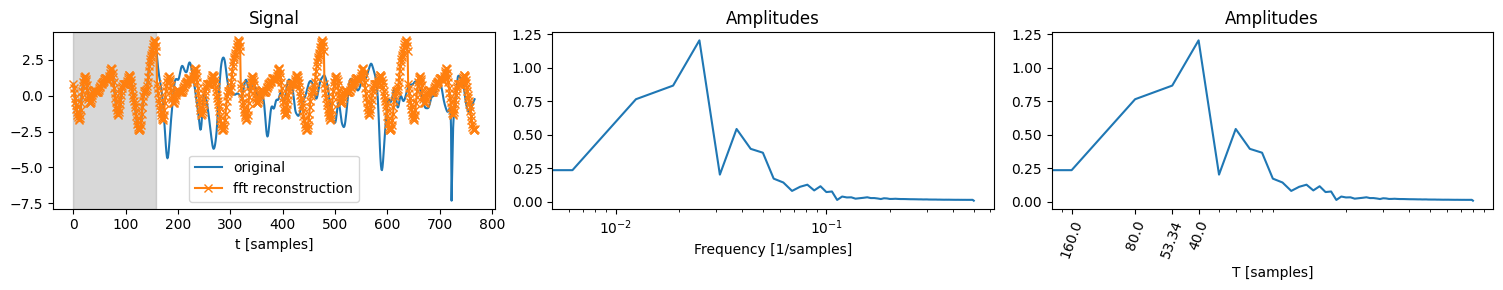

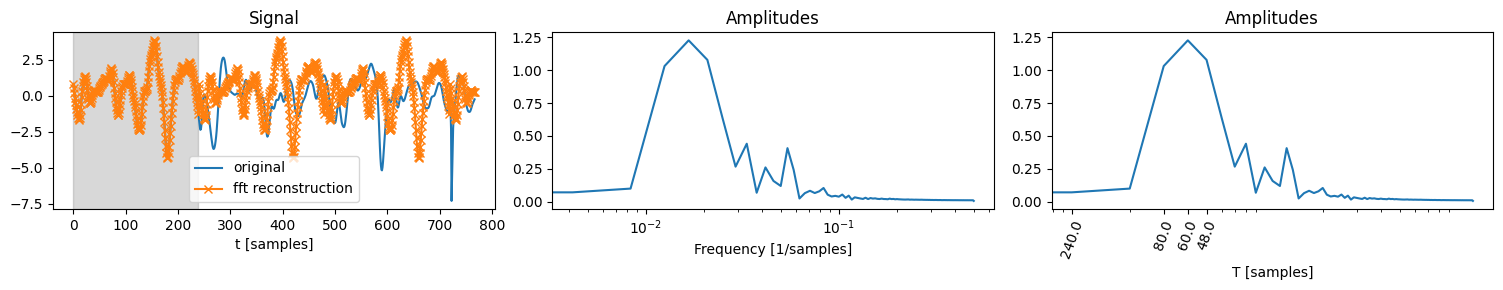

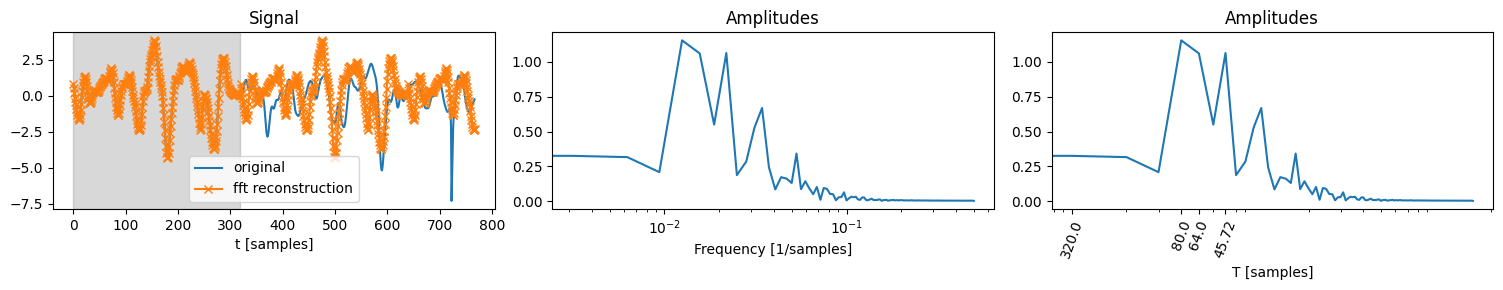

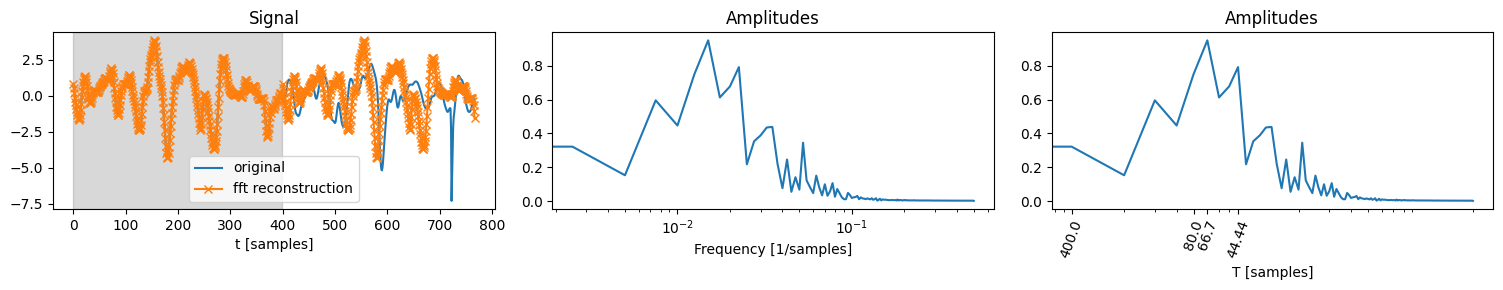

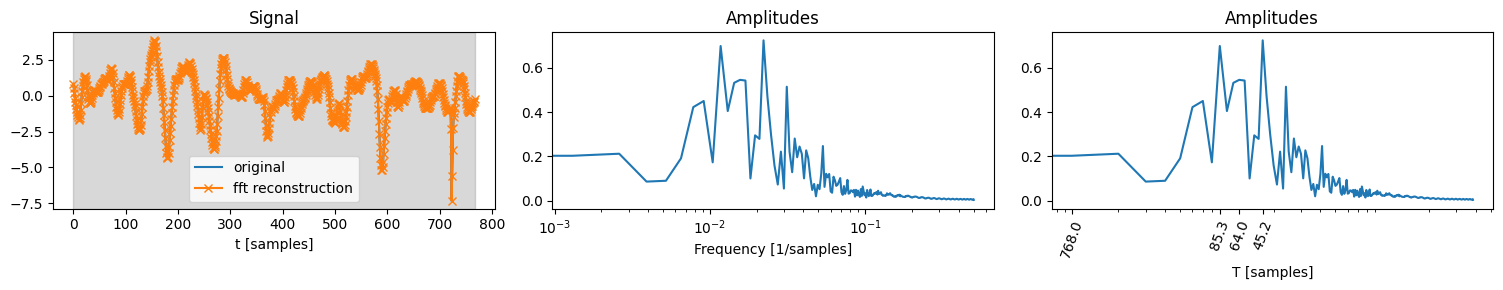

In [21]:
import pandas as pd
import torch

# Replace 'your_file.csv' with the path to your CSV file
# and 'your_column_name' with the name of the column you want to read.
csv_file = './data/data_easier.csv'
column_name = 'target'

# Read the CSV file using pandas
df = pd.read_csv(csv_file)

# Select the column and convert it to a NumPy array
column_data = df[column_name].to_numpy()

# Convert the NumPy array to a PyTorch tensor
targets = torch.tensor(column_data, dtype=torch.float32)  # or torch.float64 for double precision
targets = targets-torch.mean(targets)
print(len(targets))
plot_signal_and_fft(targets, 80)
plot_signal_and_fft(targets, 160)
plot_signal_and_fft(targets, 240)
plot_signal_and_fft(targets, 320)
plot_signal_and_fft(targets, 400)
plot_signal_and_fft(targets, len(targets))

## LSTM

We have looked at how a DFT alone can help us in predicting oiur signals and the anser is, not very well.
So let's see how a very simple LSTM performs.

Let's define the Dataset class that will feed the data to our LSTM during traing and eval.

In [22]:
import json
from typing import List
import random
import string
from datetime import datetime

class Logger:
    def __init__(self, run_name, send_to_wandb=False, id_resume=None, hyperparameters:List[str]=[]) -> None:
       
        common_kwargs={
            'project':"time-series",
            'tags': hyperparameters,
            'name': run_name,
        }
        if send_to_wandb and not id_resume:
            wandb.init(
                **common_kwargs
            )
            self.run_id = wandb.run.id
        if send_to_wandb and id_resume:
            wandb.init(
                **common_kwargs,
                id=id_resume,
                resume=True
            )
            self.run_id = id_resume
        
        if not send_to_wandb and id_resume:
            self.run_id = id_resume
        else:
            self.run_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))

        print("RUN ID", self.run_id)
        self.send_to_wandb = send_to_wandb
        
        base_dir = Path(f"./checkpoints/{self.run_id}/")
        base_dir.mkdir(parents=True, exist_ok=True)
        self.new_checkpoint_dir = Path(f"./checkpoints/{self.run_id}/{datetime.now().strftime('%d-%m-%Y_%H-%M-%S')}")
        self.new_checkpoint_dir.mkdir(parents=True, exist_ok=True)
        with open(f"{self.new_checkpoint_dir}/config.json", 'w') as f:
            json.dump({"run_name": run_name, "send_to_wandb": send_to_wandb, "id_resume": self.run_id, "hyperparameters": hyperparameters}, f)

    def log(self, data, step):
        if self.send_to_wandb:
            wandb.log(data, step)
    
    def finish(self):
        if self.send_to_wandb:
            wandb.finish()
    

            

def count_parameters(model):
    from prettytable import PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

def train(
        model, 
        train_dataset, 
        eval_dataset, 
        optimizer, 
        loss_function, 
        logger, 
        epochs_from=0, 
        epochs_to=500, 
        device='cpu', 
        bs=32, 
        ):
    print("DEVICE", device)
    model.to(device)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=bs, shuffle=True)
    for i in range(epochs_from, epochs_to + 1):
        model.train()
        train_loss = 0
        for seq, labels in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(seq.to(device))
            single_loss = loss_function(y_pred, labels.to(device))
            single_loss.backward()
            train_loss += single_loss
            optimizer.step()

        if i % 25 == 0:
            model.eval()
            val_loss = 0
            for seq, labels in eval_dataloader:
                y_pred = model(seq.to(device))
                single_loss = loss_function(y_pred, labels.to(device))
                val_loss += single_loss
            print(f'TRAIN: epoch: {i},  loss: {train_loss.item()}')
            print(f'VAL: epoch: {i},  val loss: {val_loss.item()} \n')
            logger.log({"train loss": train_loss.item(), "val loss": val_loss.item()}, i)
            if i % 100 == 0:
                torch.save(model.state_dict(), f"{logger.new_checkpoint_dir}/{i}_epochs")
        


### Small and simple LSTM

In [23]:
class TimeSeriesDataset(Dataset):
    def __init__(self, size, num_samples):
        """
        :param size: Number of samples in the dataset
        """
        self.size = size
        self.num_samples = num_samples

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal = generate_signal(num_samples=self.num_samples)
        target = torch.roll(signal, -1, dims=0)
        return signal.unsqueeze_(dim=-1), target.unsqueeze_(dim=-1)

Now let's define the LSTM model itself.

In [24]:
class LSTMPredictor(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True, num_layers=1)
        self.linear = torch.nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x = self.linear(x)
        return x

count_parameters(LSTMPredictor())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    400     |
| lstm.weight_hh_l0 |   40000    |
|  lstm.bias_ih_l0  |    400     |
|  lstm.bias_hh_l0  |    400     |
|   linear.weight   |    100     |
|    linear.bias    |     1      |
+-------------------+------------+
Total Trainable Params: 41301


41301

Let's inspect our model architetcure and initialize it.

Now we are ready to go, we just need to initialize the datasets, data loaders, optimizers and start our trainign loop.

In [25]:
LR = 0.002
SIGNAL_SIZE=105
LOOKBACK_WINDOW_SIZE=100
EPOCH_FROM = 0
EPOCH_TO = 3000
SEND_TO_WANDB = True
#### BEGIN: Load model and init Logger
model = LSTMPredictor()

# checkpoint_path = './checkpoints/VVLZNW/1/500_epochs'
checkpoint_path = None

hyperparameters = [f"LR={LR}", f"PARAMS={count_parameters(model)}", f"SIGNAL_SIZE={SIGNAL_SIZE}", f"LOOKBACK_WINDOW_SIZE={LOOKBACK_WINDOW_SIZE}"]

if checkpoint_path:
    EPOCH_FROM = int(checkpoint_path.split("/")[-1].split("_")[0])
    run_id = checkpoint_path.split("/")[-3]
    model.load_state_dict(torch.load(checkpoint_path))
    logger = Logger("small-lstm", send_to_wandb=SEND_TO_WANDB, id_resume=run_id, hyperparameters=hyperparameters)
else:
    logger = Logger("small-lstm", send_to_wandb=SEND_TO_WANDB, hyperparameters=hyperparameters)
### END
    
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_dataset = TimeSeriesDataset(size=1000, num_samples=SIGNAL_SIZE) 
eval_dataset = TimeSeriesDataset(size=1000, num_samples=SIGNAL_SIZE)  

assert EPOCH_TO > EPOCH_FROM
print(f"Training from {EPOCH_FROM} to {EPOCH_TO}")

train(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    optimizer=optimizer,
    epochs_from=EPOCH_FROM,
    epochs_to=EPOCH_TO,
    loss_function=loss_function,
    logger=logger
    )



+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    400     |
| lstm.weight_hh_l0 |   40000    |
|  lstm.bias_ih_l0  |    400     |
|  lstm.bias_hh_l0  |    400     |
|   linear.weight   |    100     |
|    linear.bias    |     1      |
+-------------------+------------+
Total Trainable Params: 41301


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roncaglionidaniele (shape-vs-texture). Use `wandb login --relogin` to force relogin


RUN ID 5W53HL
Training from 0 to 3000
DEVICE cpu
TRAIN: epoch: 0,  loss: 4.253148555755615
VAL: epoch: 0,  val loss: 2.199153184890747 

TRAIN: epoch: 25,  loss: 1.390575885772705
VAL: epoch: 25,  val loss: 1.3621937036514282 

TRAIN: epoch: 50,  loss: 0.9991466999053955
VAL: epoch: 50,  val loss: 0.9919925928115845 

TRAIN: epoch: 75,  loss: 0.48536786437034607
VAL: epoch: 75,  val loss: 0.48534858226776123 

TRAIN: epoch: 100,  loss: 0.32808917760849
VAL: epoch: 100,  val loss: 0.3068167567253113 

TRAIN: epoch: 125,  loss: 0.3549327850341797
VAL: epoch: 125,  val loss: 0.38047462701797485 

TRAIN: epoch: 150,  loss: 0.33935683965682983
VAL: epoch: 150,  val loss: 0.31405001878738403 

TRAIN: epoch: 175,  loss: 0.26200881600379944
VAL: epoch: 175,  val loss: 0.25902268290519714 

TRAIN: epoch: 200,  loss: 0.24038995802402496
VAL: epoch: 200,  val loss: 0.2341558337211609 

TRAIN: epoch: 225,  loss: 0.22656749188899994
VAL: epoch: 225,  val loss: 0.23232676088809967 

TRAIN: epoch: 25

In [26]:
logger.finish()

train loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,0.17675
val loss,0.16488


In [27]:
# model.load_state_dict(torch.load("checkpoints/0a4eos6o/500_epochs_0a4eos6o"))

Let's see how our model performs.

First of all we need to rememebr that if we feed a sequence to an LSTM model, then the prediction at point `n+1` will be based on all points before that. So when plotting the prediction the LSTM can't really mess up that much since at each step we predict on all the previous actual grounf truth values.

No surpise then that the plot looks pretty good.

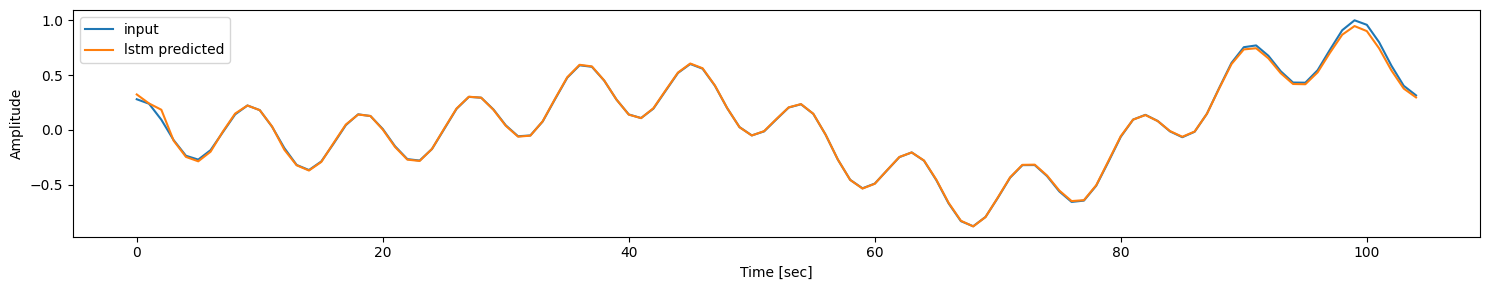

In [28]:
t, signal = generate_signal(num_samples=SIGNAL_SIZE)
pred = model(signal.view(1, len(signal), 1))
predicted_signal = pred.view(len(signal)).detach()
predicted_signal = torch.roll(predicted_signal, 1, dims=0)

# Plotting
plt.figure(figsize=(15, 3))

plt.plot(t, signal, label='input')
plt.plot(t, predicted_signal, label='lstm predicted')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

The real test is autoregressive generation, where we give the LSTM a part of the ground truth, and then use the LSTMs own output for step `n` to also predict `n+1` etc.

Let's see how we do in that case.

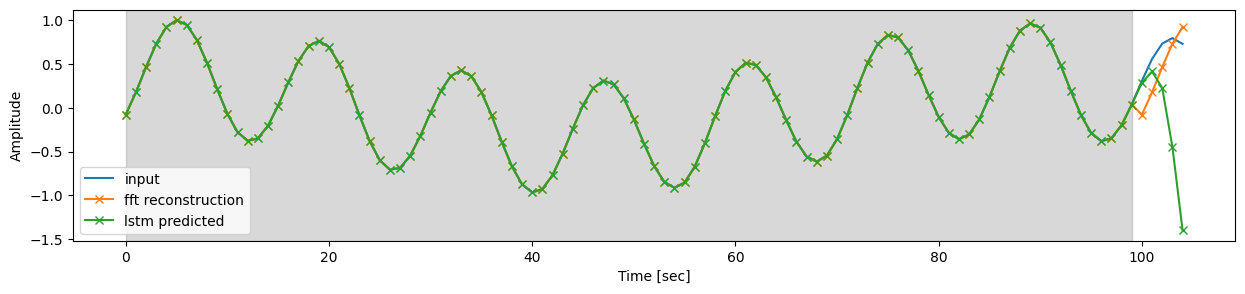

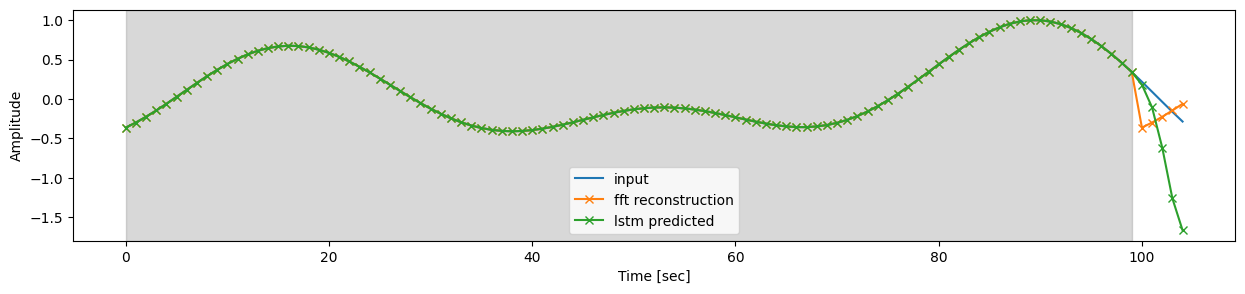

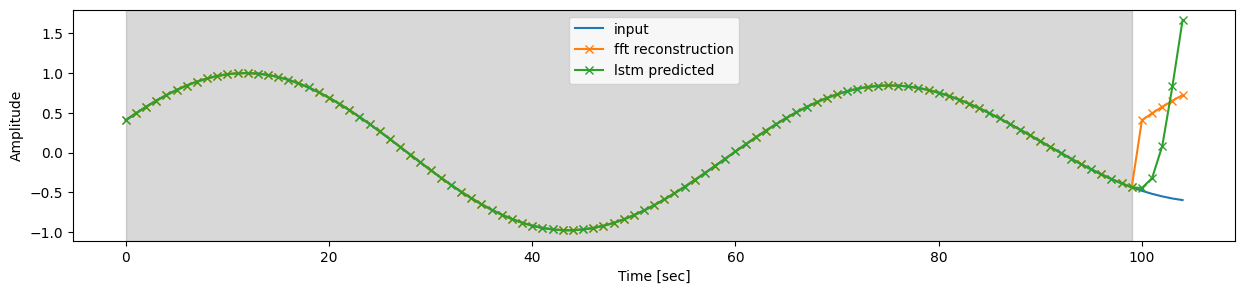

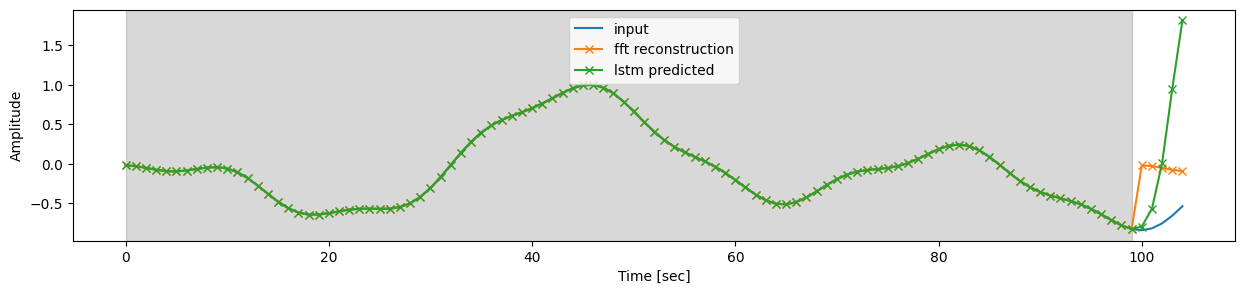

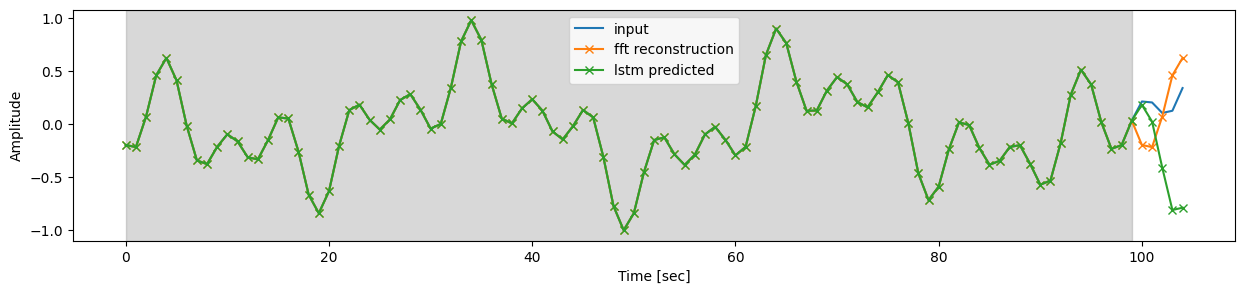

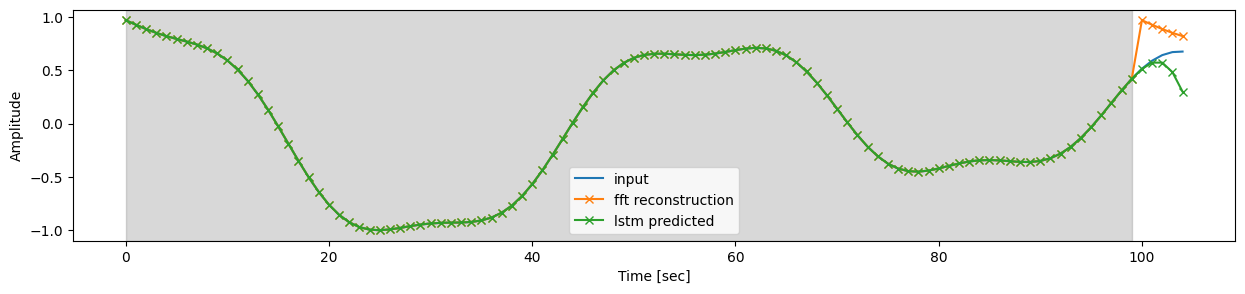

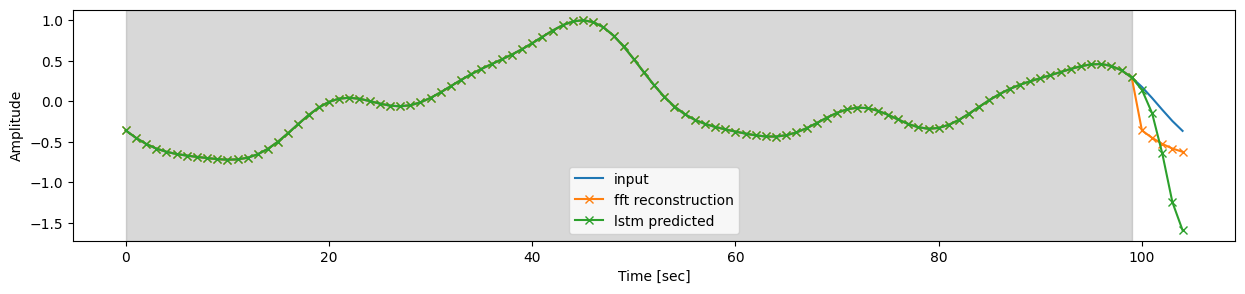

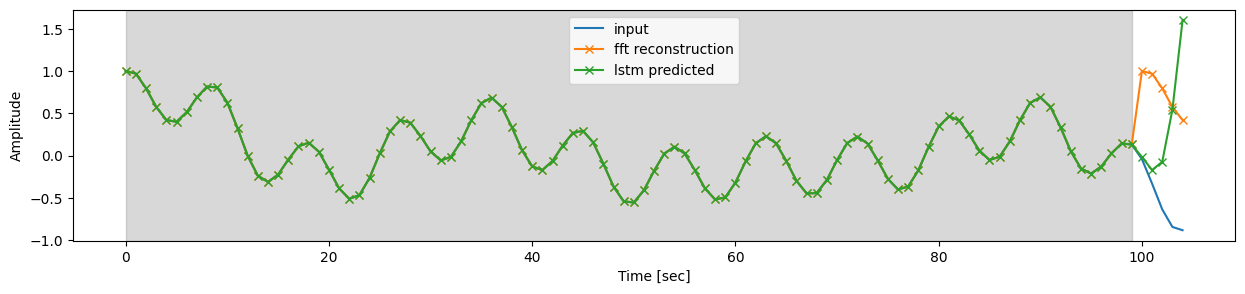

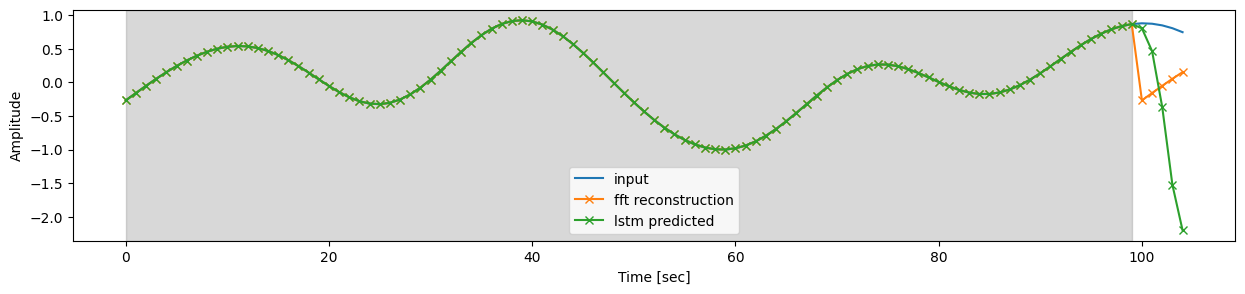

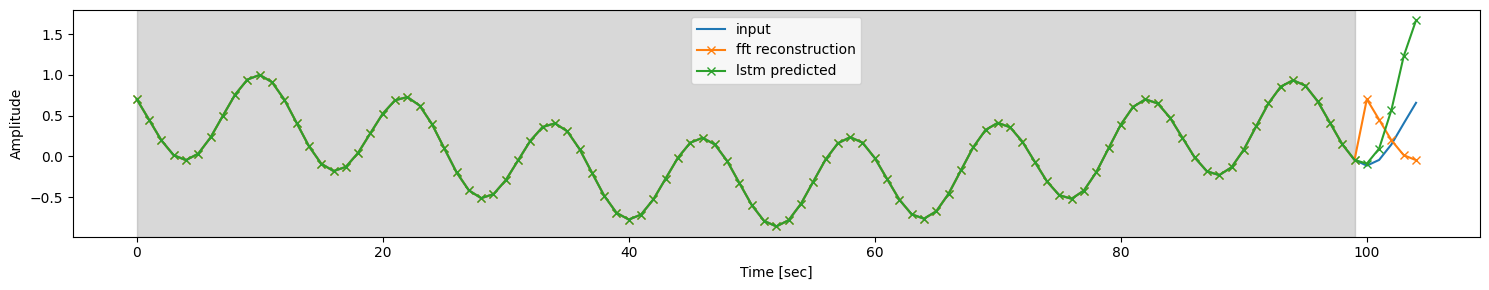

In [29]:
def lstm_autoregressive_pred(signal, N):
    signal_continuation_autoreg = torch.clone(signal)
    signal_continuation_autoreg[N:] = 0
    for i in range(len(signal[N:])):
        pred = model(signal_continuation_autoreg.view(1, len(signal_continuation_autoreg), 1))
        pred = pred.view(len(signal_continuation_autoreg)).detach()
        signal_continuation_autoreg[N+i] = pred[N+i-1]
    return signal_continuation_autoreg

N=LOOKBACK_WINDOW_SIZE
for _ in range(10):
    t, signal = generate_signal(num_samples=SIGNAL_SIZE)
    plt.figure(figsize=(15, 3))

    plt.plot(t, signal, label='input')
    plt.plot(t, reconstruct_signal_fft(signal, N),'-x', label='fft reconstruction')
    plt.plot(t, lstm_autoregressive_pred(signal,N),'-x', label='lstm predicted')
    plt.legend(loc='best')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')

    plt.axvspan(0, N-1, color='grey', alpha=0.3)


plt.tight_layout()
plt.show()

This isn't doing very well, and the loss curves are already plateauing.

### Sequence to Sequence

Perhaps the problem is that we are trying to use the model autoregressively to predict a longer sequence, even though it was trained to only ever make a prediction for the next element.

Let's try a different model architecture, one where we actually train it to produce a longer sequence directly.
Do to dis welll use an LSTM to encode the lookback window into a hidden state and we'll use another LSTM to decode that into the predicted seuquence.

In [30]:
class SeqToSeqDataset(Dataset):
    def __init__(self, size, num_samples=150, split_idx=100, lookback_window_size=100, return_decoder_input=True):
        assert num_samples > split_idx
        self.size = size
        self.num_samples = num_samples
        self.split_idx = split_idx
        self.lookback_window_size = lookback_window_size
        self.return_decoder_input = return_decoder_input

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal = generate_signal(num_samples=self.num_samples, periods_range=(2, self.lookback_window_size))
        encoder_input = signal[:self.split_idx]
        decoder_input = signal[self.split_idx-1:]
        decoder_targets = torch.roll(decoder_input, -1, dims=0)
        if self.return_decoder_input:
            return torch.concat((encoder_input, decoder_input[:-1]), dim=0).unsqueeze_(dim=-1), decoder_targets[:-1].unsqueeze_(dim=-1)
        else:
            return encoder_input.unsqueeze_(dim=-1), decoder_targets[:-1].unsqueeze_(dim=-1)

In [31]:
class GruEncoder(torch.nn.Module):
    def __init__(self, hidden_size) -> None:
        super(GruEncoder, self).__init__()
        self.gru = torch.nn.GRU(input_size=1, hidden_size=hidden_size, batch_first=True, num_layers=1)
        
    def forward(self, encoder_input):
        """
        Args:
            encoder_input: torch.Tensor[N, L_encoder, 1]

        Returns:
            torch.Tensor: [N, h_encoder + fft]
        """    
        _, h_n = self.gru(encoder_input) # h_n =[1, N, h_dim]
        fft_result = torch.fft.rfft(encoder_input, dim=1, norm="forward")
        amplitudes = torch.abs(fft_result) # = [N, f_dim, 1]
        phases =  torch.angle(fft_result)
        return torch.concat((h_n, amplitudes.view(1,encoder_input.shape[0],-1), phases.view(1,encoder_input.shape[0],-1)), dim=-1).squeeze_(dim=0)
    
class GruDecoderCell(torch.nn.Module):
    def __init__(self, hidden_size) -> None:
        super(GruDecoderCell, self).__init__()
        self.gru_cell = torch.nn.GRUCell(input_size=1, hidden_size=hidden_size)
    
    def forward(self, input, h):    
        return self.gru_cell(input, h)
    

class SeqToSeqGru(torch.nn.Module):
    def __init__(self, encoder_input_length=100, decoder_input_length=50) -> None:
        super(SeqToSeqGru, self).__init__()
        self.encoder_in_dim = encoder_input_length
        self.decoder_in_dim = decoder_input_length
        
        self.encoder_hidden_dim = 10
        self.enocoder_output_dim = self.encoder_hidden_dim + 2*(int(self.encoder_in_dim/2) + 1) # hidden dim + cat 2 * rfft

        self.encoder = GruEncoder(hidden_size=self.encoder_hidden_dim)
        self.decoder_cell = GruDecoderCell(hidden_size=self.enocoder_output_dim)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_1 = torch.nn.Linear(self.enocoder_output_dim, int(self.enocoder_output_dim/2))
        self.linear_2 = torch.nn.Linear(int(self.enocoder_output_dim/2), 1) 
        
    def forward(self, input):
        """
        Args:
            encoder_input: torch.Tensor[N, L_encoder, 1]
            decoder_input: torch.Tensor[N, L_decoder, 1] | None 

        Returns:
            torch.Tensor: [L_decoder, 1]
        """        
        if input.shape[1] == self.encoder_in_dim:
            encoder_input = input
            decoder_input = None
        elif input.shape[1] == self.encoder_in_dim + self.decoder_in_dim:
            encoder_input, decoder_input = input[:,:self.encoder_in_dim,:], input[:,self.encoder_in_dim:,:]
        else:
            raise "input shape mismatch"
        # assert encoder_input.shape[1] == self.encoder_in_dim
        # assert decoder_input.shape[1] == self.decoder_in_dim

        # Compress all of lookback window into hidden state with encoder and concat with fft
        h_n_augemented = self.encoder(encoder_input) # [N, h_encoder + fft]
        
        # init hidden state for decoder is the compressed lookback window hidden state from the encoder   
        h_decoder = h_n_augemented
        decoder_outputs = torch.empty((encoder_input.shape[0], self.decoder_in_dim, h_n_augemented.shape[-1]), dtype=torch.float) # [N, dec_in, h_enc+fft] 
        mlp_outputs = torch.empty((encoder_input.shape[0], self.decoder_in_dim, 1), dtype=torch.float) # [N, dec_in, 1] 
        # teacher forcing: feed actual sequence to decoder
        if decoder_input is not None: # Loop over inputs and feed them to decoder cell while updating the hidden state
            for i in range(self.decoder_in_dim):
                input_element = decoder_input[:,i,:]
                h_decoder = self.decoder_cell(input_element, h_decoder) # [N, h_enc + fft]
                decoder_outputs[:, i, :] = h_decoder
            x = self.linear_1(decoder_outputs)
            x = self.leaky_relu(x)
            x = self.linear_2(x)
            return x
        else: # No teacher forcing: autoregress
            # init the autoregression with the last value in the lookback window
            decoder_input = encoder_input[:,-1,:] #
            for i in range(self.decoder_in_dim):
                h_decoder = self.decoder_cell(decoder_input, h_decoder)
                # decoder_outputs[:, i, :] = h_decoder
                x = self.linear_1(h_decoder)
                x = self.leaky_relu(x)
                x = self.linear_2(x)
                decoder_input = x.clone().detach()
                mlp_outputs[:, i, :] = x
            return mlp_outputs
        
count_parameters(SeqToSeqGru(encoder_input_length=100, decoder_input_length=50))


+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|     encoder.gru.weight_ih_l0    |     30     |
|     encoder.gru.weight_hh_l0    |    300     |
|      encoder.gru.bias_ih_l0     |     30     |
|      encoder.gru.bias_hh_l0     |     30     |
| decoder_cell.gru_cell.weight_ih |    336     |
| decoder_cell.gru_cell.weight_hh |   37632    |
|  decoder_cell.gru_cell.bias_ih  |    336     |
|  decoder_cell.gru_cell.bias_hh  |    336     |
|         linear_1.weight         |    6272    |
|          linear_1.bias          |     56     |
|         linear_2.weight         |     56     |
|          linear_2.bias          |     1      |
+---------------------------------+------------+
Total Trainable Params: 45415


45415

In [32]:
LR = 0.002
SIGNAL_SIZE=105
LOOKBACK_WINDOW_SIZE=100
PREDICTION_SIZE=5
assert LOOKBACK_WINDOW_SIZE + PREDICTION_SIZE == SIGNAL_SIZE
EPOCH_FROM = 0
EPOCH_TO = 3000
SEND_TO_WANDB = True

#### BEGIN: Load model and init Logger
model = SeqToSeqGru(encoder_input_length=LOOKBACK_WINDOW_SIZE, decoder_input_length=PREDICTION_SIZE)

# checkpoint_path = './checkpoints/VVLZNW/1/500_epochs'
checkpoint_path = None

hyperparameters = [f"LR={LR}", f"PARAMS={count_parameters(model)}", f"SIGNAL_SIZE={SIGNAL_SIZE}", f"LOOKBACK_WINDOW_SIZE={LOOKBACK_WINDOW_SIZE}", f"PREDICTION_SIZE={PREDICTION_SIZE}"]

if checkpoint_path:
    EPOCH_FROM = int(checkpoint_path.split("/")[-1].split("_")[0])
    run_id = checkpoint_path.split("/")[-3]
    model.load_state_dict(torch.load(checkpoint_path))
    logger = Logger("enocder-decoder-lstm", send_to_wandb=SEND_TO_WANDB, id_resume=run_id, hyperparameters=hyperparameters)
else:
    logger = Logger("enocder-decoder-lstm", send_to_wandb=SEND_TO_WANDB, hyperparameters=hyperparameters)
### END
    
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_dataset = SeqToSeqDataset(size=1000, num_samples=SIGNAL_SIZE, split_idx=LOOKBACK_WINDOW_SIZE, return_decoder_input=True) 
eval_dataset = SeqToSeqDataset(size=1000, num_samples=SIGNAL_SIZE, split_idx=LOOKBACK_WINDOW_SIZE, return_decoder_input=False)  

assert EPOCH_TO > EPOCH_FROM
print(f"Training from {EPOCH_FROM} to {EPOCH_TO}")

train(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    optimizer=optimizer,
    epochs_from=EPOCH_FROM,
    epochs_to=EPOCH_TO,
    loss_function=loss_function,
    logger=logger
    )



+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|     encoder.gru.weight_ih_l0    |     30     |
|     encoder.gru.weight_hh_l0    |    300     |
|      encoder.gru.bias_ih_l0     |     30     |
|      encoder.gru.bias_hh_l0     |     30     |
| decoder_cell.gru_cell.weight_ih |    336     |
| decoder_cell.gru_cell.weight_hh |   37632    |
|  decoder_cell.gru_cell.bias_ih  |    336     |
|  decoder_cell.gru_cell.bias_hh  |    336     |
|         linear_1.weight         |    6272    |
|          linear_1.bias          |     56     |
|         linear_2.weight         |     56     |
|          linear_2.bias          |     1      |
+---------------------------------+------------+
Total Trainable Params: 45415


RUN ID CKOBK3
Training from 0 to 3000
DEVICE cpu
TRAIN: epoch: 0,  loss: 4.388464450836182
VAL: epoch: 0,  val loss: 4.319097518920898 

TRAIN: epoch: 25,  loss: 0.5327506065368652
VAL: epoch: 25,  val loss: 2.443162679672241 

TRAIN: epoch: 50,  loss: 0.2513550817966461
VAL: epoch: 50,  val loss: 2.1959521770477295 

TRAIN: epoch: 75,  loss: 0.13654153048992157
VAL: epoch: 75,  val loss: 2.72782039642334 

TRAIN: epoch: 100,  loss: 0.09969203174114227
VAL: epoch: 100,  val loss: 1.4660788774490356 

TRAIN: epoch: 125,  loss: 0.07858271896839142
VAL: epoch: 125,  val loss: 1.5324313640594482 

TRAIN: epoch: 150,  loss: 0.08868931233882904
VAL: epoch: 150,  val loss: 1.6074926853179932 

TRAIN: epoch: 175,  loss: 0.06154822185635567
VAL: epoch: 175,  val loss: 1.3860915899276733 

TRAIN: epoch: 200,  loss: 0.09157481789588928
VAL: epoch: 200,  val loss: 1.243523359298706 

TRAIN: epoch: 225,  loss: 0.06291664391756058
VAL: epoch: 225,  val loss: 1.3807008266448975 

TRAIN: epoch: 250,  

In [33]:
logger.finish()

train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▅▃▃▂▂▂▂▂▂▁▂▁▂▂▁▂▂▃▁▂▂▁▁▂▁▂▁▁▂▂▂▂▁▁▁▂▂▁▁
train loss,0.01448
val loss,0.5305


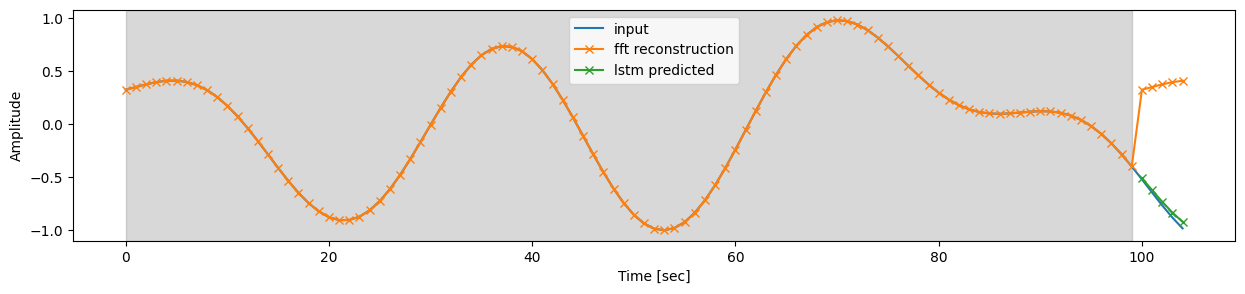

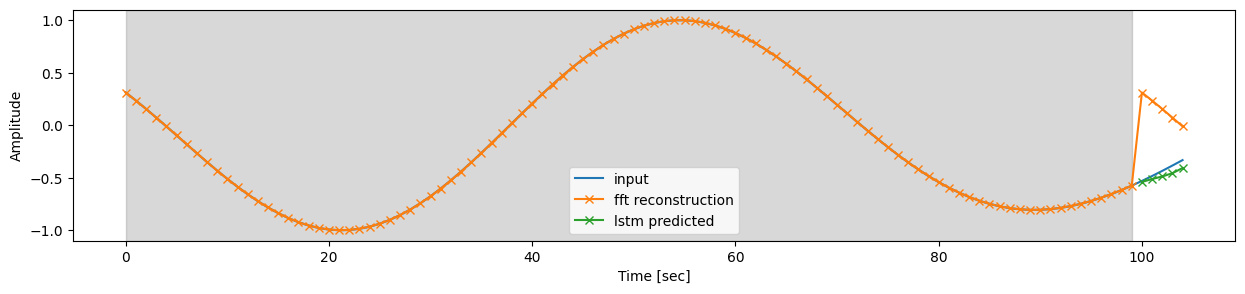

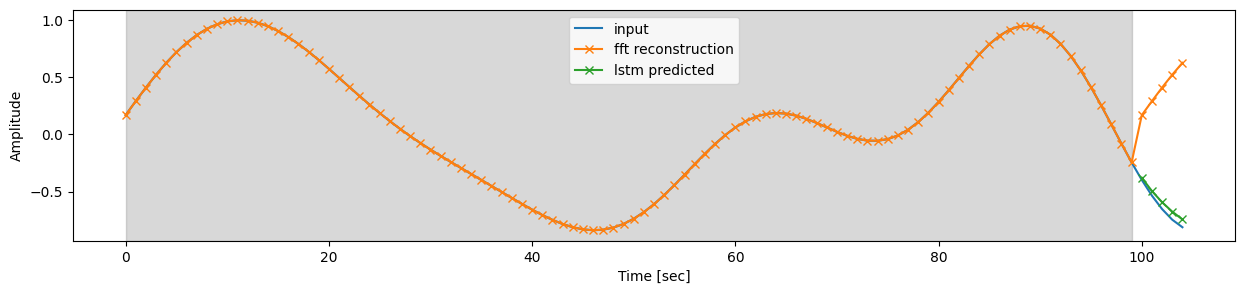

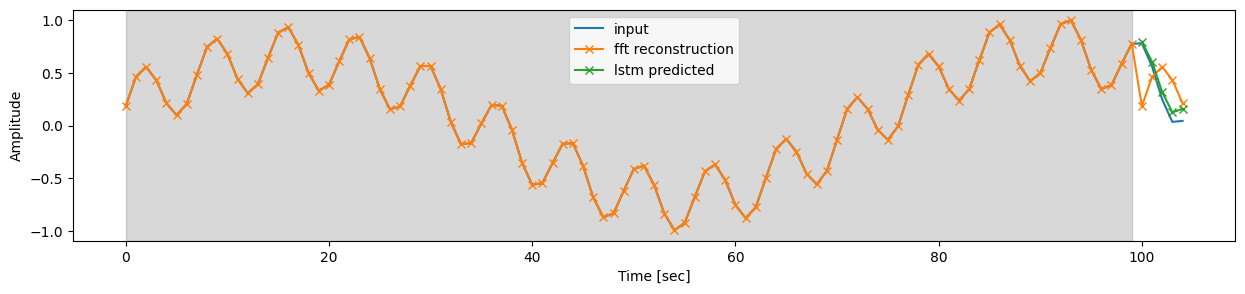

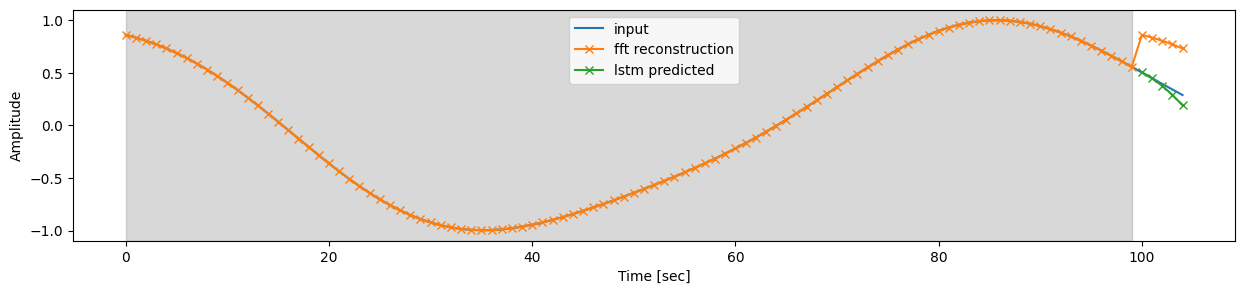

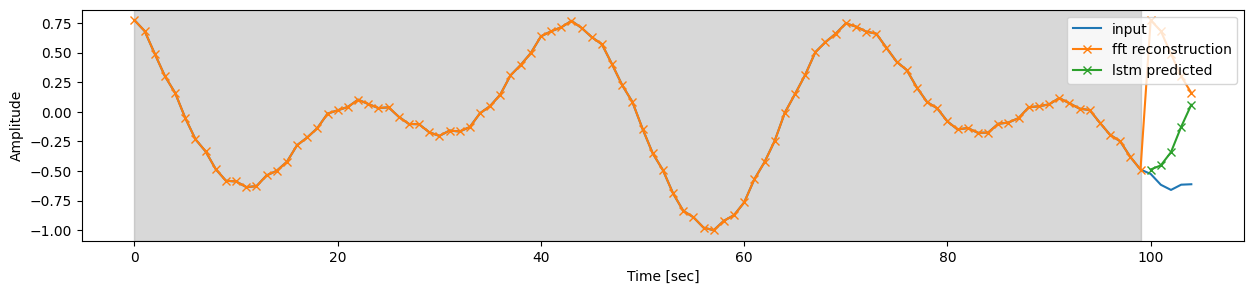

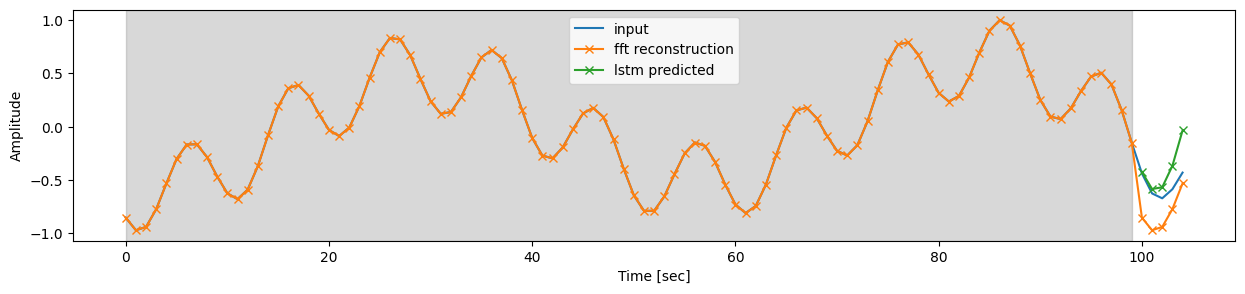

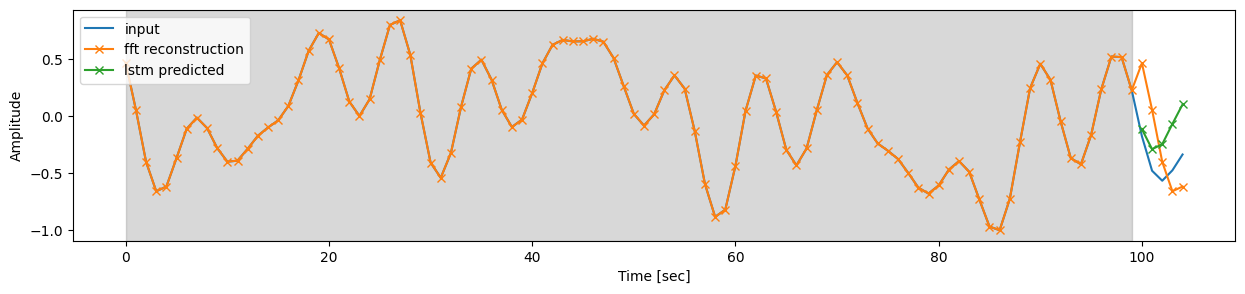

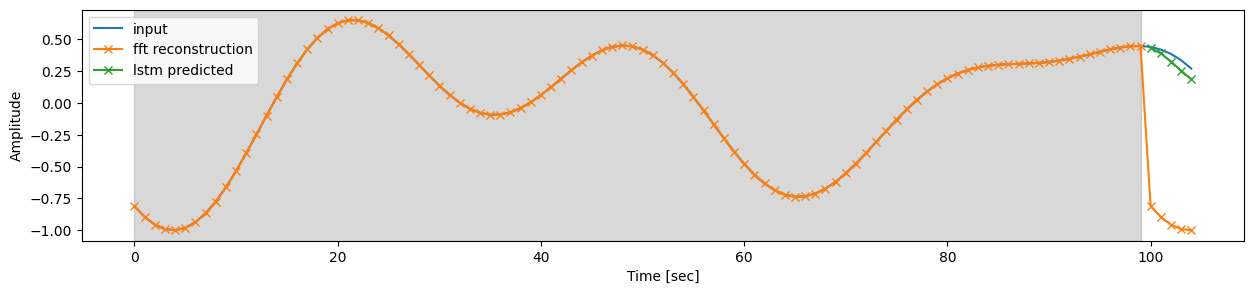

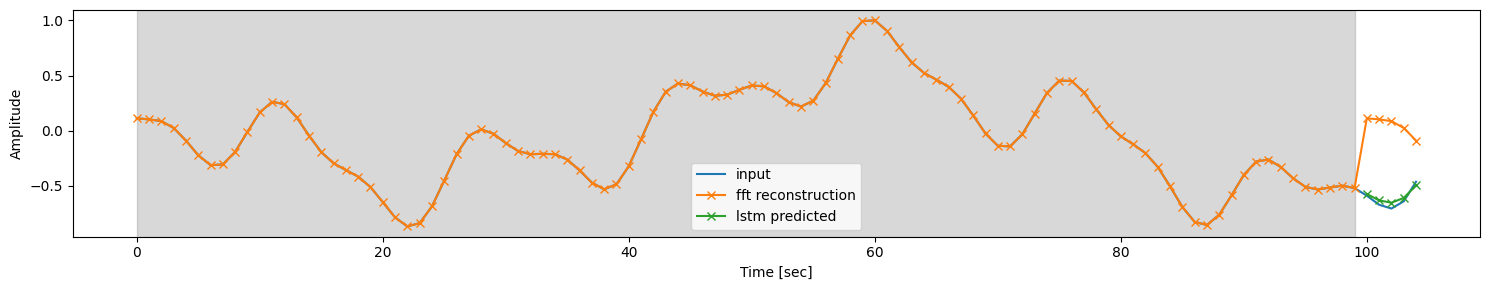

In [34]:
def lstm_pred(signal, N):
    signal = torch.clone(signal)
    pred = model(signal[:N].view(1,N,1))
    return pred.view(SIGNAL_SIZE-N).detach()

for _ in range(10):
    t, signal = generate_signal(num_samples=SIGNAL_SIZE, periods_range=(2,100))
    plt.figure(figsize=(15, 3))

    plt.plot(t, signal, label='input')
    plt.plot(t, reconstruct_signal_fft(signal, LOOKBACK_WINDOW_SIZE),'-x', label='fft reconstruction')
    plt.plot(range(LOOKBACK_WINDOW_SIZE, SIGNAL_SIZE), lstm_pred(signal, LOOKBACK_WINDOW_SIZE),'-x', label='lstm predicted')
    plt.legend(loc='best')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')

    plt.axvspan(0, LOOKBACK_WINDOW_SIZE-1, color='grey', alpha=0.3)


plt.tight_layout()
plt.show()